## Plotting CO concentrations maps in Python

This notebook will help you plot CO concentration maps for any day and any location.

The first step is to import the libraries needed to open and read the datasets (netcdf files).

In [1]:
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
import cartopy.mpl.ticker as cticker

We set the input parameters, i.e. the date, the IASI instrument and the overpass time (day = 9:30 a.m. or night = 9:30 p.m.). Active periods for the different IASI instruments:
- IASI/Metop A: from 2007/10/01 to 2020/12/31
- IASI/Metop B: from 2013/03/08 
- IASI/Metop C: from 2019/09/22

In [2]:
YEAR = 2025
MONTH = 1
DAY = 15
SAT = 'c'  
directory = '/home/selviga/codes/ACAM'
filename = f'{directory}/IASI_METOP{SAT.upper()}_L2_CO_{YEAR}{MONTH:02d}{DAY:02d}_ULB-LATMOS_ICDR_V6.7.1.nc'

Let's open the dataset using xarray.

In [3]:
ds = xr.open_dataset(filename)
ds # print the dataset

<xarray.Dataset>
Dimensions:                            (time: 470187, nlayers: 19,
                                        npressures: 20)
Coordinates:
  * time                               (time) float64 2.01e+04 ... 2.01e+04
    latitude                           (time) float32 ...
    longitude                          (time) float32 ...
Dimensions without coordinates: nlayers, npressures
Data variables: (12/21)
    AERIStime                          (time) float64 ...
    hour                               (time) uint8 ...
    minute                             (time) uint8 ...
    second                             (time) uint8 ...
    solar_zenith_angle                 (time) float32 ...
    satellite_zenith_angle             (time) float32 ...
    ...                                 ...
    CO_total_column                    (time) float32 ...
    CO_total_column_error              (time) float32 ...
    CO_degrees_of_freedom              (time) float32 ...
    air_partial_column_profile         (time, nlayers) float32 ...
    atmosphere_pressure_grid           (time, npressures) float32 ...
    averaging_kernel_matrix            (time, nlayers, nlayers) float32 ...
Attributes: (12/31)
    title:                       IASI/METOPC ULB-LATMOS carbon monoxide (CO) ...
    institution:                 ULB-LATMOS for algorithm development ; EUMET...
    product_version:             6.7.1
    history:                     2025-01-16 06:22:35 (date of data extraction...
    summary:                     This dataset contains Level 2 carbon monoxid...
    source:                      EUMETSAT IASI Level 2 carbon monoxide (CO) d...
    ...                          ...
    creator_name:                ULB-LATMOS
    contact_email:               contact form at http://iasi.aeris-data.fr/co...
    data_policy:                 see https://iasi.aeris-data.fr/data-use-policy/
    time_coverage_start:         20250115T000000Z
    time_coverage_end:           20250115T235959Z
    id:                          IASI_METOPC_L2_CO_20250115_ULB-LATMOS_ICDR_V...

Another way to get the variables.

In [4]:
list(ds.variables)

['time',
 'AERIStime',
 'hour',
 'minute',
 'second',
 'latitude',
 'longitude',
 'solar_zenith_angle',
 'satellite_zenith_angle',
 'orbit_number',
 'scanline_number',
 'pixel_number',
 'ifov_number',
 'retrieval_quality_flag',
 'surface_altitude',
 'CO_apriori_partial_column_profile',
 'CO_partial_column_profile',
 'CO_partial_column_error',
 'CO_total_column',
 'CO_total_column_error',
 'CO_degrees_of_freedom',
 'air_partial_column_profile',
 'atmosphere_pressure_grid',
 'averaging_kernel_matrix']

Variables have attributes (i.e.additional information). 

In [5]:
ds.CO_total_column

<xarray.DataArray 'CO_total_column' (time: 470187)>
[470187 values with dtype=float32]
Coordinates:
  * time       (time) float64 2.01e+04 2.01e+04 2.01e+04 ... 2.01e+04 2.01e+04
    latitude   (time) float32 ...
    longitude  (time) float32 ...
Attributes:
    units:                                                  mol m-2
    long_name:                                              retrieved carbon ...
    standard_name:                                          atmosphere_mole_c...
    ancillary_variables:                                    CO_total_column_e...
    multiplication_factor_to_convert_to_molecules_per_cm2:  6.02214086e+19

In [6]:
cotc_in_molecules_per_cm2 = ds.CO_total_column*ds.CO_total_column.multiplication_factor_to_convert_to_molecules_per_cm2
print('in molecules/cm² : ', cotc_in_molecules_per_cm2.values) # get the values only
print('in mol/m² : ', ds.CO_total_column.values)

in molecules/cm² :  [1.1622936e+18 9.7749161e+17 8.6725993e+17 ... 1.7118819e+18 1.9158365e+18
 1.9448557e+18]
in mol/m² :  [0.01930034 0.01623163 0.01440119 ... 0.02842647 0.03181321 0.03229509]


We need to get latitudes and longitudes to plot IASI CO data. 

In [7]:
longitudes = ds.longitude.values
latitudes = ds.latitude.values

We can check the size (shape) of each variable. 

In [8]:
print(longitudes.shape)
print(latitudes.shape)
print(cotc_in_molecules_per_cm2.shape)

(470187,)
(470187,)
(470187,)


When working IASI CO data, only pixels that are flagged "good quality" must be used (see the product user manual for more information : https://acsaf.org/products/iasi_co.php). 

In [10]:
ds.retrieval_quality_flag

<xarray.DataArray 'retrieval_quality_flag' (time: 470187)>
array([1, 2, 2, ..., 1, 2, 2], dtype=uint8)
Coordinates:
  * time       (time) float64 2.01e+04 2.01e+04 2.01e+04 ... 2.01e+04 2.01e+04
    latitude   (time) float32 -56.67 -56.7 -56.97 -56.57 ... 20.1 20.02 20.25
    longitude  (time) float32 -40.62 -41.53 -41.49 ... -31.6 -32.02 -30.81
Attributes:
    long_name:  retrieval quality flag summarizing processing flags
    comment:    = 2 for the most reliable pixels; = 1 for the valuable pixels...

In [12]:
good_quality_only = (ds.retrieval_quality_flag.values == 2)
lons = longitudes[good_quality_only] # mask data where retrieval quality flag is not equal to 2
lats = latitudes[good_quality_only]
cotc = cotc_in_molecules_per_cm2[good_quality_only]

In [13]:
print(lons.shape)
print(lats.shape)
print(cotc.shape)

(341672,)
(341672,)
(341672,)


Plotting data using matplotlib and cartopy

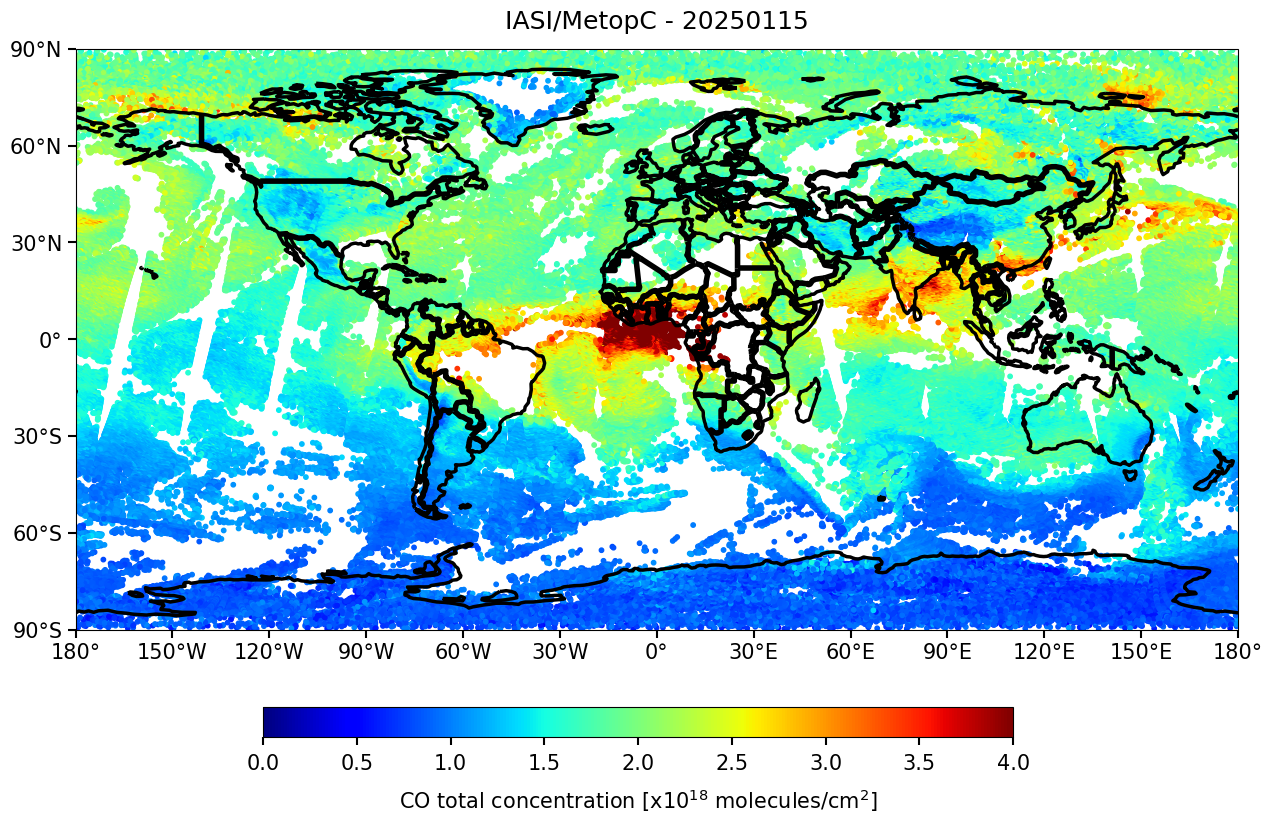

In [14]:
# We create a 15x15 dpi figure with the ‘PlateCarrée’ projection
fig = plt.figure(figsize=(15,15))
axes = plt.subplot(projection=ccrs.PlateCarree())

# We add the coasts and borders of countries
axes.coastlines(linewidth=2.5, zorder=10)
axes.add_feature(cf.BORDERS, linewidth=2.5, edgecolor='black', zorder=10)

# We add the CO concentrations to the figure, ranging by the values vmin and vmax
min_val = 0
max_val = 4
pt_size = 10 # size of the IASI pixels plotted on the figure 

img = axes.scatter(lons, lats, c=cotc*1e-18, 
                   vmin=min_val, vmax=max_val, s=pt_size,
                   transform=ccrs.PlateCarree(),
                   cmap='jet')

# The x-axis (longitudes) and y-axis (latitudes) are also plotted (step of 30°).
axes.set_xticks(np.arange(-180,181,30), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
axes.xaxis.set_major_formatter(lon_formatter)
axes.set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
axes.yaxis.set_major_formatter(lat_formatter)
axes.xaxis.set_tick_params(width=1.5, length=6, labelsize=15) # size of the label ticks 
axes.yaxis.set_tick_params(width=1.5, length=6, labelsize=15)

# Add the colorbar associated with CO concentrations
cbar_ax = fig.add_axes([0.25, 0.23, 0.5, 0.02]) # x, y, length and width of the colorbar 
cbar = fig.colorbar(img, cax = cbar_ax, orientation='horizontal')
cbar.set_label(r'CO total concentration [x10$^{18}$ molecules/cm$^{2}$]', fontsize=15, labelpad=10) # colorbar title
cbar.ax.tick_params(labelsize=15, pad=6, width=1.5, length=6) # colorbar ticks 

# Figure title
axes.set_title(f'IASI/Metop{SAT.upper()} - {YEAR}{MONTH:02}{DAY:02d}', 
               fontsize=18, y=1.02)
plt.show()

### Plotting only day time or night time data 

Daytime (nighttime) data correspond to data where the solar zenith angle is less than (greater than) 90°.

In [15]:
# Create a mask for day and night data
sza = ds.solar_zenith_angle.values
day_only = sza < 90
night_only = sza > 90

In [18]:
lons_day = longitudes[day_only & good_quality_only]
lats_day = latitudes[day_only & good_quality_only]
cotc_day = cotc_in_molecules_per_cm2[day_only & good_quality_only]
print(lons_day.shape, lats_day.shape, cotc_day.shape)

(184647,) (184647,) (184647,)


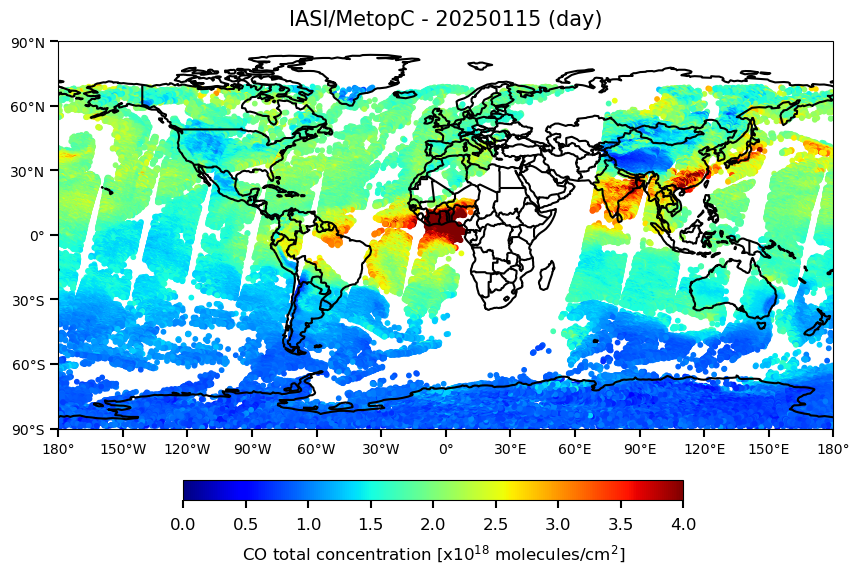

In [26]:
# Plotting day time data only

fig = plt.figure(figsize=(10,10))
axes = plt.subplot(projection=ccrs.PlateCarree())
axes.coastlines(linewidth=1.5, zorder=10)
axes.add_feature(cf.BORDERS, linewidth=1.5, edgecolor='black', zorder=10)

img = axes.scatter(lons_day, lats_day, c=cotc_day*1e-18, 
                   vmin=min_val, vmax=max_val, s=pt_size,
                   transform=ccrs.PlateCarree(),
                   cmap='jet')

axes.set_xticks(np.arange(-180,181,30), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
axes.xaxis.set_major_formatter(lon_formatter)
axes.set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
axes.yaxis.set_major_formatter(lat_formatter)
axes.xaxis.set_tick_params(width=1.5, length=6, labelsize=10) 
axes.yaxis.set_tick_params(width=1.5, length=6, labelsize=10)

cbar_ax = fig.add_axes([0.25, 0.23, 0.5, 0.02]) 
cbar = fig.colorbar(img, cax = cbar_ax, orientation='horizontal')
cbar.set_label(r'CO total concentration [x10$^{18}$ molecules/cm$^{2}$]', fontsize=12, labelpad=8) 
cbar.ax.tick_params(labelsize=12, pad=6, width=1.5, length=6) 

axes.set_title(f'IASI/Metop{SAT.upper()} - {YEAR}{MONTH:02}{DAY:02d} (day)', 
               fontsize=15, y=1.02)
plt.show()

### Plotting data for a specific region

In [27]:
# Define the region of interest 
lon_min, lon_max = 60, 150
lat_min, lat_max = -10, 45
mask_region = (longitudes > lon_min) & (longitudes < lon_max) & (latitudes > lat_min) & (latitudes < lat_max) 

In [28]:
lons_night_roi = longitudes[night_only & good_quality_only & mask_region]
lats_night_roi = latitudes[night_only & good_quality_only & mask_region]
cotc_night_roi = cotc_in_molecules_per_cm2[night_only & good_quality_only & mask_region]

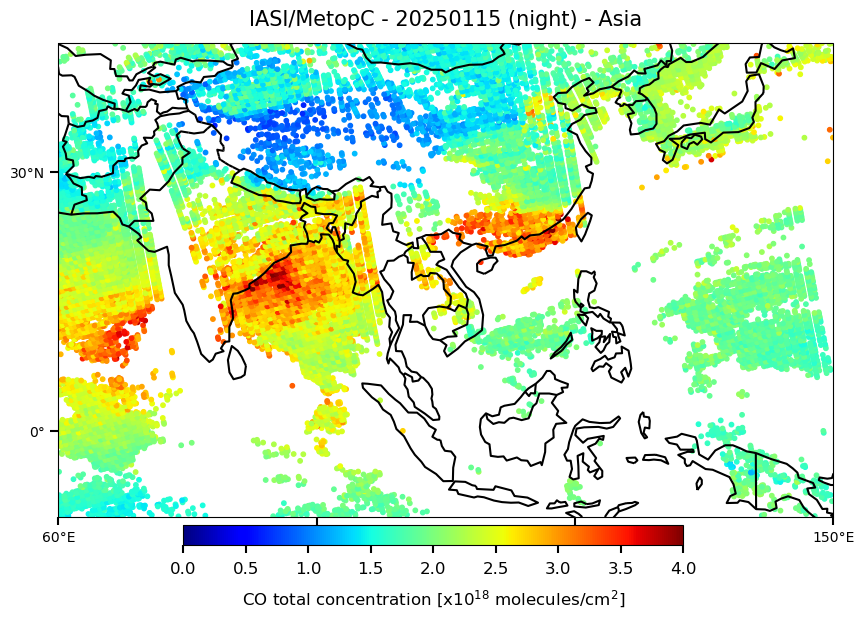

In [32]:
# Plotting night time data only for the region of interest

fig = plt.figure(figsize=(10,10))
axes = plt.subplot(projection=ccrs.PlateCarree())
axes.coastlines(linewidth=1.5, zorder=10)
axes.add_feature(cf.BORDERS, linewidth=1.5, edgecolor='black', zorder=10)

img = axes.scatter(lons_night_roi, lats_night_roi, c=cotc_night_roi*1e-18, 
                   vmin=min_val, vmax=max_val, s=pt_size,
                   transform=ccrs.PlateCarree(),
                   cmap='jet')

axes.set_xticks(np.arange(-180,181,30), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
axes.xaxis.set_major_formatter(lon_formatter)
axes.set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
axes.yaxis.set_major_formatter(lat_formatter)
axes.xaxis.set_tick_params(width=1.5, length=6, labelsize=10) 
axes.yaxis.set_tick_params(width=1.5, length=6, labelsize=10)

cbar_ax = fig.add_axes([0.25, 0.23, 0.5, 0.02]) 
cbar = fig.colorbar(img, cax = cbar_ax, orientation='horizontal')
cbar.set_label(r'CO total concentration [x10$^{18}$ molecules/cm$^{2}$]', fontsize=12, labelpad=8) 
cbar.ax.tick_params(labelsize=12, pad=6, width=1.5, length=6) 

axes.set_title(f'IASI/Metop{SAT.upper()} - {YEAR}{MONTH:02}{DAY:02d} (night) - Asia', 
               fontsize=15, y=1.02)

axes.set_xlim(lon_min, lon_max) # set the limits of the region 
axes.set_ylim(lat_min, lat_max)

plt.show()

### Working with gridded data (spatial binning or spatial aggregation)

In [45]:
from scipy.stats import binned_statistic_2d

In [68]:
# Define the gridstep and longitudes and latitudes of the grid
gridstep = 0.5
lon_grid = np.arange(lon_min, lon_max + gridstep, gridstep)
lat_grid = np.arange(lat_min, lat_max + gridstep, gridstep)
lon2d, lat2d = np.meshgrid(lon_grid, lat_grid) # create the grid 
print(lon_grid.shape, lon2d.shape)

(181,) (111, 181)


In [59]:
# Aggregate the data on the grid 
cotc_grid_night_roi, lon_edges, lat_edges, binnumber = binned_statistic_2d(lons_night_roi, lats_night_roi, cotc_night_roi, statistic='mean', bins=[lon_grid, lat_grid])
cotc_grid_night_roi.shape

(180, 110)

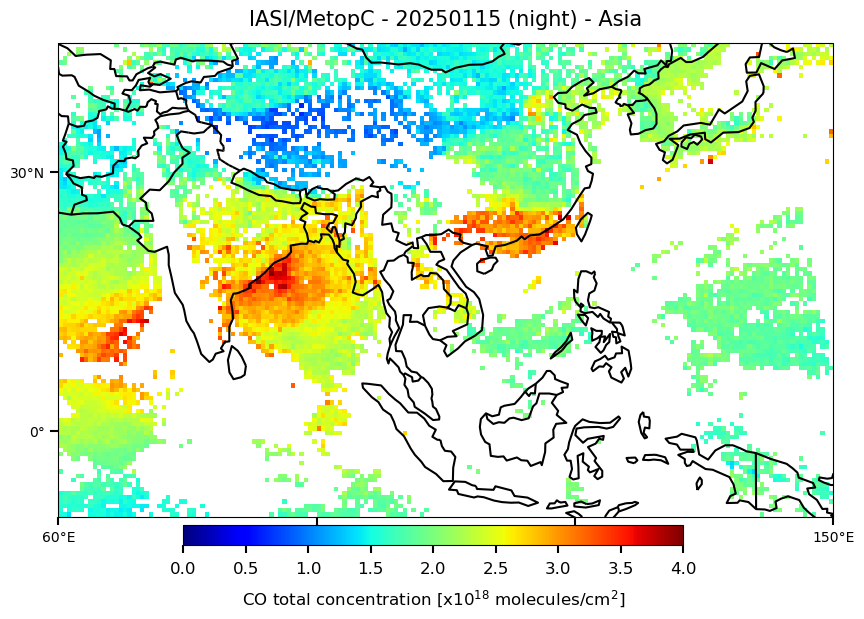

In [64]:
# Define a new grid with centered (lon,lat) for each grid cell
lon_centers = (lon_edges[:-1] + lon_edges[1:]) / 2
lat_centers = (lat_edges[:-1] + lat_edges[1:]) / 2
lon2d_center, lat2d_center = np.meshgrid(lon_centers, lat_centers)

# We need to transpose the data to use pcolormesh for plotting
cotc_grid_night_roi = cotc_grid_night_roi.T

fig = plt.figure(figsize=(10,10))
axes = plt.subplot(projection=ccrs.PlateCarree())
axes.coastlines(linewidth=1.5, zorder=10)
axes.add_feature(cf.BORDERS, linewidth=1.5, edgecolor='black', zorder=10)

img = axes.pcolormesh(lon2d_center, lat2d_center, cotc_grid_night_roi*1e-18, 
                   vmin=min_val, vmax=max_val,
                   transform=ccrs.PlateCarree(),
                   cmap='jet')

axes.set_xticks(np.arange(-180,181,30), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
axes.xaxis.set_major_formatter(lon_formatter)
axes.set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
axes.yaxis.set_major_formatter(lat_formatter)
axes.xaxis.set_tick_params(width=1.5, length=6, labelsize=10) 
axes.yaxis.set_tick_params(width=1.5, length=6, labelsize=10)

cbar_ax = fig.add_axes([0.25, 0.23, 0.5, 0.02]) 
cbar = fig.colorbar(img, cax = cbar_ax, orientation='horizontal')
cbar.set_label(r'CO total concentration [x10$^{18}$ molecules/cm$^{2}$]', fontsize=12, labelpad=8) 
cbar.ax.tick_params(labelsize=12, pad=6, width=1.5, length=6) 

axes.set_title(f'IASI/Metop{SAT.upper()} - {YEAR}{MONTH:02}{DAY:02d} (night) - Asia', 
               fontsize=15, y=1.02)

axes.set_xlim(lon_min, lon_max) 
axes.set_ylim(lat_min, lat_max)

plt.show()